RGB images of cifar, Dense would explode in parameters (too big).

So i use Conv2D autoencoder, which handles images more efficiently, keeps spatial features (edges, textures, colors).

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [2]:
# Loadding CIFAR-10 (RGB, 32x32x3)  3 channels

(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0  #normalizing it

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step


In [12]:
print("Train shape:", x_train.shape)  # (50000, 32, 32, 3) 50k images 32x32 3 channels as rgb


Train shape: (50000, 32, 32, 3)


In [14]:
# Building my  Conv2D Autoencoder
# Building my Conv2D Autoencoder
class SusnataConvAutoencoder(tf.keras.Model):
    def __init__(self):
        super(SusnataConvAutoencoder, self).__init__()

        #Encoder
        self.encoder = models.Sequential([
            layers.Input(shape=(32, 32, 3)),   # Input shape: 32x32 with 3 RGB channels (H, W, C)

            # Conv2D layer: output will have 32 channels or feature maps, kernel size = 3x3
            layers.Conv2D(32, (3,3), activation='relu', padding='same'),

            # MaxPooling2D reduces spatial dimension with stride=2 → output: 16x16x32
            layers.MaxPooling2D((2,2), padding='same'),

            # Another Conv2D layer: increases channel depth to 64 → output: 16x16x64
            layers.Conv2D(64, (3,3), activation='relu', padding='same'),

            # MaxPooling2D reduces again with stride=2 → output: 8x8x64
            layers.MaxPooling2D((2,2), padding='same')
        ])
        # Final representation is 8x8x64.
        # 8x8 is HxW and 64 channels = 64 learned feature maps.
        # Input to decoder will be this compressed latent vector.

        # Decoder
        self.decoder = models.Sequential([
            # Conv2DTranspose upsamples: 8x8x64 → 16x16x64
            layers.Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same'),

            # Conv2DTranspose upsamples: 16x16x64 → 32x32x32
            layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same'),

            # Final Conv2D: reconstructs back to RGB → 32x32x3
            layers.Conv2D(3, (3,3), activation='sigmoid', padding='same')
            # Sigmoid ensures outputs are between [0,1], since images are normalized before we divided by 2555.
        ])

    #  Forward Pass
    def call(self, x):
        encoded = self.encoder(x)        # Compress input → latent space
        decoded = self.decoder(encoded)  # Reconstruct from latent → original
        return decoded

In [15]:
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data() # no y as unsupervised from cifar dataset
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

print("Train shape:", x_train.shape)  # (50000, 32, 32, 3)
print("Test shape:", x_test.shape)    # (10000, 32, 32, 3)

Train shape: (50000, 32, 32, 3)
Test shape: (10000, 32, 32, 3)


In [16]:
autoencoder = SusnataConvAutoencoder()  #Instantiate Autoencoder

In [17]:
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError()) # mse as continous used adam as optimizer

In [18]:
history = autoencoder.fit(
    x_train, x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test, x_test)
)
#crerating a history object to see loss  # x train we are trying to recreate again xtrain

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.0242 - val_loss: 0.0055
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0052 - val_loss: 0.0045
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0043 - val_loss: 0.0038
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0038 - val_loss: 0.0035
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0027 - val_loss: 0.0026


In [19]:
autoencoder.encoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,392 (75.75 KB)

 Trainable params: 19,392 (75.75 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
autoencoder.decoder.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose                │ (None, 16, 16, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,259 (219.76 KB)

 Trainable params: 56,259 (219.76 KB)

 Non-trainable params: 0 (0.00 B)

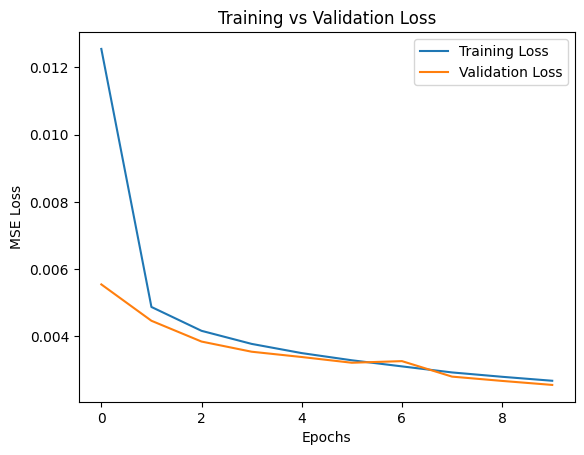

In [21]:
#Plotting  loss curves from (history object)

#plot shows no big gap between traina nd validation no overfitting hence my model is generalizing well on unseen data

import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

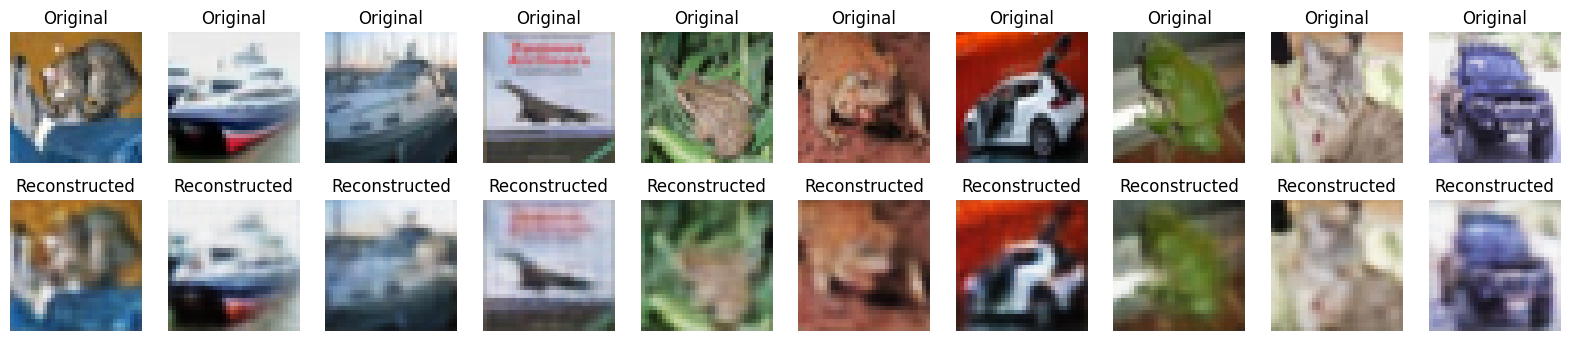

In [22]:
# Getting reconstructions of 10 images

#Visualizing original vs reconstructed images
n = 10
decoded_imgs = autoencoder(x_test[:n])

plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis("off")

    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("Reconstructed")
    plt.axis("off")

plt.show()

# My Key Takeaways:
#  Autoencoder successfully reconstructs CIFAR-10 images, retaining overall structure and colors.
# - Outputs are blurry because pixel-level MSE loss does not enforce sharpness

#As Humans we  focus on textures and edges, while MSE loss only checks pixel intensity difference rgb values, leading to smoother (blurry) reconstructions.

# Encoder compresses images into latent 8x8x64 feature maps, which capture higher-level features.
# Training vs validation loss shows no overfitting, model generalizes well.
#  For higher quality reconstructions, VAEs or GAN-based autoencoders can be explored.